# AIM

- Combine Nickil's Features with my features.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import xgboost as xgb
import lightgbm as lgb
import xgbfir

from MulticoreTSNE import MulticoreTSNE as TSNE

import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Helper Code

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

In [5]:
class XGBoostLeaves(BaseEstimator, ClassifierMixin):
    params = {
        'objective': 'binary:logistic',
        'eta': .1,
        'max_depth': 4,
        'silent': 1,
        'nthread': 4,
        'seed': SEED
    }
    
    def __init__(self, num_leaves):
        self.num_leaves = num_leaves
        
    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, y)
        self.model = xgb.train(self.params, dtrain, self.num_leaves)
        
    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X), pred_leaf=True)

## Paths

In [39]:
# TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission28.feather')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev9/tr.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev9/val.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission28_val.feather')
OOF_PATH       = os.path.join(basepath, 'oof_preds/submission39_oof.pkl')

## Load Data

In [7]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

print(train.shape, ' ', test.shape)

(458388, 12)   (78941, 12)
CPU times: user 153 ms, sys: 85.3 ms, total: 238 ms
Wall time: 1.99 s


In [8]:
ntrain = len(train); ntrain

458388

## Data Subset

In [8]:
train = train.loc[train.communication_type.isin(['Upcoming Events',
                                                 'Newsletter',
                                                 'Hackathon',
                                                 'Corporate'
                                                ])]

ntrain = len(train)

## Feature Engineering

### Load interim data

In [22]:
%%time

traintest = pd.read_feather(f'{INTERIM_PATH}')

CPU times: user 230 ms, sys: 36 ms, total: 266 ms
Wall time: 267 ms


### Additional Features

In [23]:
%%time

# number of digits in the subject line.
digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

# whether subject line has punctuation or not.
punctuation_pattern = re.compile(r'[!.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

# interaction between open rate and click rate.
traintest.loc[:, 'click_to_open']      = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

# Number of keywords in subject.
traintest.loc[:, 'num_keywords']       = traintest.subject.map(lambda x: len(x.split(' ')))

# Number of short keywords in subject.
traintest.loc[:, 'num_short_keywords'] = traintest.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

# Ratio of short to total keywords.
traintest.loc[:, 'ratio_short_total']  = traintest.num_short_keywords / traintest.num_keywords

# Total number of characters in the subject.
traintest.loc[:, 'num_characters']     = traintest.subject.map(lambda x: len(x))

# Number of times first keyword was used in the past
traintest.loc[:, 'first_keyword_count'] = traintest.groupby('first_keyword')['first_keyword'].transform(lambda x: len(x))

# Number of times second keyword was used in the past
traintest.loc[:, 'second_keyword_count'] = traintest.groupby('second_keyword')['second_keyword'].transform(lambda x: len(x))

# Number of times third keyword was used in the past
traintest.loc[:, 'third_keyword_count'] = traintest.groupby('third_keyword')['third_keyword'].transform(lambda x: len(x))

# Label Encode First Keyword
traintest.loc[:, 'first_keyword'] = pd.factorize(traintest.first_keyword)[0]

# Label Encode Second Keyword
traintest.loc[:, 'second_keyword'] = pd.factorize(traintest.second_keyword)[0]

# Label Encode Third Keyword
traintest.loc[:, 'third_keyword'] = pd.factorize(traintest.third_keyword)[0]

# Bag of communication types
bag_comm_types = traintest.groupby(['user_id']).agg({'communication_type': lambda x: '_'.join(sorted(list(map(np.str, x.unique()))))})['communication_type']
traintest.loc[:, 'bag_of_comm_type'] = traintest.user_id.map(bag_comm_types)
traintest.loc[:, 'bag_of_comm_type'] = pd.factorize(traintest.loc[:, 'bag_of_comm_type'])[0]

CPU times: user 20.5 s, sys: 1.02 s, total: 21.6 s
Wall time: 21.5 s


### Nickil's Features

In [24]:
%%time

# traintest.loc[:, 'ordered_user_id_diff']   = traintest.sort_values(['user_id', 'send_date'])['user_id'].diff().reindex(traintest.index)
# traintest.loc[:, 'unordered_user_id_diff'] = traintest['user_id'].diff()
traintest.loc[:, 'total_seconds_elapsed']  = traintest.groupby('user_id')['send_date'].transform(np.ptp).dt.total_seconds()

# traintest.loc[:, 'mean_day']   = traintest.groupby('user_id')['send_day'].transform('mean')
# traintest.loc[:, 'mean_hour']  = traintest.groupby('user_id')['send_hour'].transform('mean')

# traintest.loc[:, 'min_day']   = traintest.groupby('user_id')['send_day'].transform('min')
# traintest.loc[:, 'min_hour']  = traintest.groupby('user_id')['send_hour'].transform('min')

# traintest.loc[:, 'max_day']   = traintest.groupby('user_id')['send_day'].transform('max')
# traintest.loc[:, 'max_hour']  = traintest.groupby('user_id')['send_hour'].transform('max')

traintest.loc[:, 'campaign_count'] = traintest.groupby('user_id')['campaign_id'].transform('count')

# traintest.loc[:, 'mean_of_total_links'] = traintest.groupby('user_id')['total_links'].transform('mean')
# traintest.loc[:, 'mean_of_no_of_internal_links'] = traintest.groupby('user_id')['no_of_internal_links'].transform('mean')
# traintest.loc[:, 'mean_of_no_of_images'] = traintest.groupby('user_id')['no_of_images'].transform('mean')
# traintest.loc[:, 'mean_of_no_of_sections'] = traintest.groupby('user_id')['no_of_sections'].transform('mean')

# traintest.loc[:, 'user_id_open_mean'] = traintest.groupby('user_id')['is_open'].transform('mean').fillna(0.30)

traintest.loc[:, 'communication_type_count'] = traintest['communication_type'].map(traintest['communication_type'].value_counts())
traintest.loc[:, 'subject_count']    = traintest['subject'].map(traintest['subject'].value_counts())

CPU times: user 1min 21s, sys: 1.66 s, total: 1min 23s
Wall time: 1min 22s


### Features Definition

In [25]:
FEATURES = ['communication_type', 
            'send_day', 
            'send_hour', 
            'send_weekday',
            'total_links', 
            'no_of_internal_links', 
            'no_of_images', 
            'no_of_sections',
            'num_emails_sent', 
            'num_diff_email_types', 
            'most_sent_type', 
            'diff_hour', 
            'avg_diff_send_date',
            'user_id_click_mte_mean', 
            'user_id_open_mte_mean',
            'user_age', 
            'subject_num_digits', 
            'subject_has_punctuation',
            'click_to_open', 
            'num_keywords', 
            'num_short_keywords',
            'ratio_short_total', 
            'num_characters',
            'first_keyword_count', 
            'second_keyword_count', 
            'third_keyword_count',
            'comm_type_click_mte_mean',
            'comm_type_click_mean', 
            'comm_type_click_std',
            'comm_type_click_max', 
            'comm_type_click_min',
            'comm_type_click_median',
            'first_keyword', 
            'second_keyword',
            'third_keyword',
            'num_hackathon_emails',
            'bag_of_comm_type',
            'total_seconds_elapsed', 
            'campaign_count', 
            'communication_type_count', 
            'subject_count'
           ]

In [26]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type          0
send_day                    0
send_hour                   0
send_weekday                0
total_links                 0
no_of_internal_links        0
no_of_images                0
no_of_sections              0
num_emails_sent             0
num_diff_email_types        0
most_sent_type              0
diff_hour                   0
avg_diff_send_date          0
user_id_click_mte_mean      0
user_id_open_mte_mean       0
user_age                    0
subject_num_digits          0
subject_has_punctuation     0
click_to_open               0
num_keywords                0
num_short_keywords          0
ratio_short_total           0
num_characters              0
first_keyword_count         0
second_keyword_count        0
third_keyword_count         0
comm_type_click_mte_mean    0
comm_type_click_mean        0
comm_type_click_std         0
comm_type_click_max         0
comm_type_click_min         0
comm_type_click_median      0
first_keyword               0
second_key

## Higher Order Interactions

In [27]:
%%time

num_leaves = 20

train  = traintest.iloc[:ntrain].loc[:, FEATURES]
target = traintest.iloc[:ntrain]['is_click'].values
test   = traintest.iloc[ntrain:].loc[:, FEATURES]

xgbl = XGBoostLeaves(num_leaves=num_leaves)
xgbl_encoded = cross_val_predict(xgbl, train, y=target, cv=5, n_jobs=1)
xgbl_leaves  = pd.DataFrame(xgbl_encoded,
                            columns=['leaf_%s'%i for i in range(num_leaves)],
                            index=train.index.values
                           )

xgbl.fit(train, target)
xgbl_test_encoded = xgbl.predict(test)

xgbl_leaves_test = pd.DataFrame(xgbl_test_encoded, 
                   columns=['leaf_%s'%i for i in range(num_leaves)],
                   index=test.index.values
                   )


train = pd.concat((train, xgbl_leaves), axis=1)
test  = pd.concat((test, xgbl_leaves_test), axis=1)

CPU times: user 2min 28s, sys: 1.85 s, total: 2min 29s
Wall time: 42.4 s


In [28]:
%%time

pca = PCA(n_components=2, whiten=True, random_state=SEED)
traintest_pca = pca.fit_transform(scale(traintest.loc[:, FEATURES]))

traintest_pca = pd.DataFrame(traintest_pca, columns=['pca1', 'pca2'], index=traintest.index)

train = pd.concat((train, traintest_pca.iloc[:ntrain]), axis=1)
test  = pd.concat((test, traintest_pca.iloc[ntrain:]), axis=1)

CPU times: user 3.25 s, sys: 992 ms, total: 4.24 s
Wall time: 4.72 s


In [29]:
# update feature list
FEATURES = FEATURES + list(xgbl_leaves.columns)
FEATURES = FEATURES + list(traintest_pca.columns)

### Train Test Split

In [30]:
X_trn = traintest.iloc[:ntrain].loc[:, FEATURES]
y_trn = traintest.iloc[:ntrain].is_click.values

X_val = traintest.iloc[ntrain:].loc[:, FEATURES]
y_val = traintest.iloc[ntrain:]['is_click'].values

print(X_trn.shape, X_val.shape)

(458388, 63) (78941, 63)


### Modelling

In [40]:
# params = {
#           'objective': 'binary',
#           'metric': 'auc',
#           'learning_rate': 0.01,
#           'random_state': SEED,
#           'max_depth': 12,
#           'num_leaves': 20,
#           'colsample_bytree': 0.7,
#           'subsample': 0.8,
#           'min_child_weight': 1
#          }

params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .01,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'lambda_l2': 10,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 30000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.655446	eval's auc: 0.649783
[40]	train's auc: 0.673076	eval's auc: 0.651695
[60]	train's auc: 0.673151	eval's auc: 0.651786
[80]	train's auc: 0.676421	eval's auc: 0.651799
[100]	train's auc: 0.677088	eval's auc: 0.651846
[120]	train's auc: 0.680338	eval's auc: 0.65638
[140]	train's auc: 0.689812	eval's auc: 0.655447
[160]	train's auc: 0.69062	eval's auc: 0.652895
[180]	train's auc: 0.691017	eval's auc: 0.652829
[200]	train's auc: 0.69436	eval's auc: 0.653218
[220]	train's auc: 0.695233	eval's auc: 0.652684
Early stopping, best iteration is:
[135]	train's auc: 0.689366	eval's auc: 0.658386


In [41]:
# oof preds
val_preds = m.predict(X_val, num_iteration=m.best_iteration)
joblib.dump(val_preds, f'{OOF_PATH}')

['/home/abhishek/Desktop/src/ml/lordofmachines/oof_preds/submission39_oof.pkl']

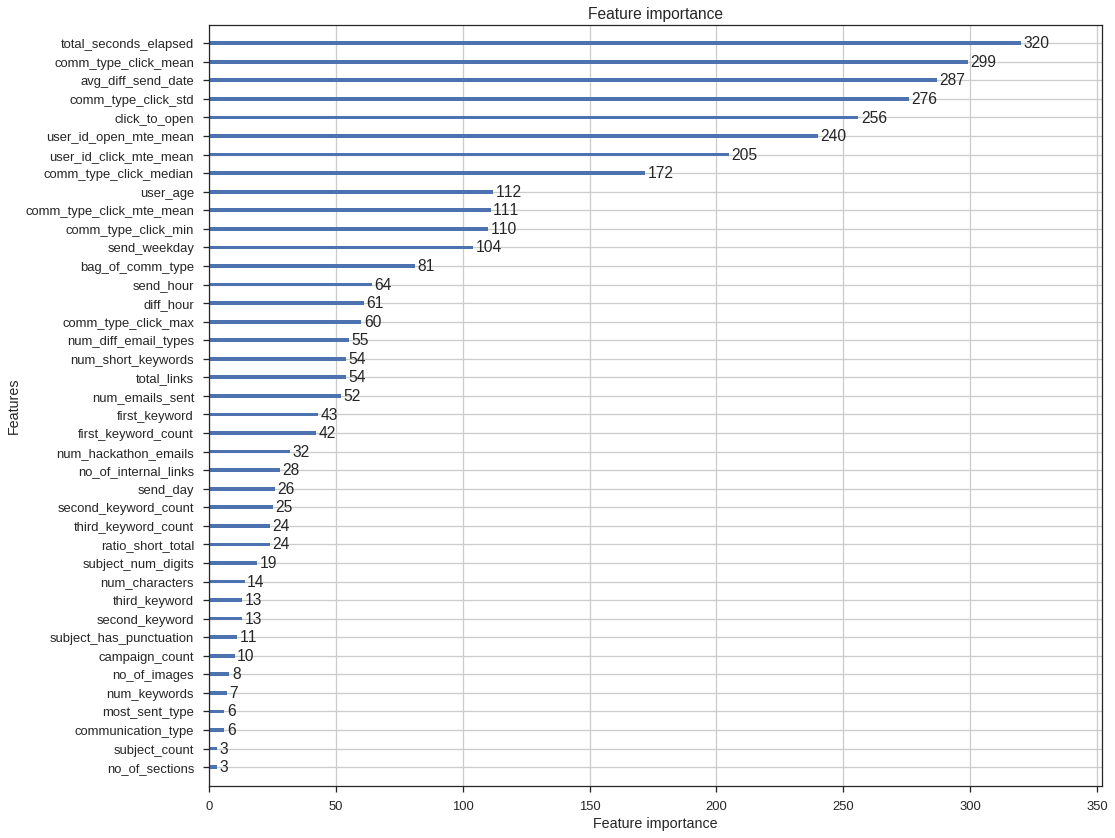

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 14))
lgb.plot_importance(m, ax=ax);

## Full Training

In [14]:
params = {
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': (0.01 / 1.1),
          'seed': SEED,
          'max_depth': 12,
          'num_leaves': 20,
          'colsample_bytree': 0.7,
          'subsample': 0.8,
          'min_child_weight': 1
         }

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(623 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

## Submission

In [15]:
sub             = traintest.iloc[ntrain:][['id']].copy()
sub['is_click'] = preds
sub.to_csv('../submissions/submission39.csv', index=False)